In [1]:
import pandas as pd
import konlpy
from konlpy.tag import Okt
%matplotlib inline
import matplotlib.pyplot as plt
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras

import IPython
import kerastuner as kt
okt = Okt()

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [2]:
with open("./negative_words_self.txt", encoding='utf-8') as neg:
    negative = neg.readlines()

negative = [neg.replace("\n", "") for neg in negative]

with open("./positive_words_self.txt", encoding='utf-8') as pos:
    positive = pos.readlines() 
    
negative = [neg.replace("\n", "") for neg in negative]
positive = [pos.replace("\n", "") for pos in positive]

In [3]:
data = pd.read_excel("데이터 셋.xlsx", sep=",")

In [5]:
naver = pd.read_excel("네이버 뉴스 데이터 셋.xlsx")
daum = pd.read_excel("다음 뉴스 데이터 셋.xlsx")

In [7]:
data.isnull().sum()

청원번호     0
청원제목     0
참여인원     0
카테고리     0
청원시작일    0
청원마감일    0
청원내용     0
dtype: int64

In [8]:
len(data)

2816

In [10]:
daum

,Unnamed: 0,title,contents,date
0,0,"'구미 여아' 언니 전남편 ""김씨, 희대의 악마이자 살인마..엄벌 해달라""",\n\n\n\n\n 구미 3세 여아 사망 사건 관련 숨진 여아의...,20210412
1,1,"임오경 의원, '폭행 주장' 국민청원에 ""악의적 허위사실"" 반박",\n\n\n\n\n 더불어민주당 임오경 의원. 사진=연합뉴스\n...,20210224
2,2,"반중 정서에 강원 차이나타운 반대 청원, 하루새 10만 넘었다!",\n\n\n\n\n 청와대 국민청원 게시판./사진=캡쳐\n ...,20210331
3,3,"'사관생도' 국민청원에 보훈처 차장 ""안타깝다""..국방부 ""조사 않을 것""",\n\n\n\n\n 지난 26일 청와대 국민청원 게시판에 자신을...,20210329
4,4,글로벌 반도체 패권경쟁에 높아지는 이재용 사면론,\n\n\n\n\n 충수염 수술 후 병원에 입원해 있던 이재용 ...,20210417
...,...,...,...,...
826,826,"김어준 ""吳 당선됐으니 없어지라고..세금 탈루? 선 넘지마""",\n\n\n\n\n TBS라디오 ‘김어준의 뉴스공장’ 진행자 김...,20210416
827,827,'조두순에 복지급여 주지 마라' 국민청원 답 못듣는다,\n\n\n\n\n 아동 성폭행 혐의로 징역 12년을 복역 후 ...,20210208
828,828,"""스쿨존에 왜 트럭이 다녀요"" 초등생 국민청원 호소","\n\n\n\n\n 국민청원 게시판, 국민일보\n ...",20210319
829,829,"""검은 이미지 투영, 아파트 이름서 LH 빼달라"" LH 입주민 분노의 靑 청원",\n\n\n\n\n 사진은 경기도 성남시 LH 경기지역본부 모습...,20210319


In [11]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ",
                 "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"',
                 "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta',
                 '∅': '', '³': '3', 'π': 'pi', } 
def clean_punc(text, punct, mapping):
    for p in mapping: 
        text = text.replace(p, mapping[p]) 
        
    for p in punct: 
        text = text.replace(p, f' {p} ') 
        
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''} 
    for s in specials:
        text = text.replace(s, specials[s])
        
    return text.strip()


In [12]:
def preprocessing(text):
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('(<([^>]+)>)', '', text)
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

In [ ]:
for i in range(0, len(data)):
    data['청원내용'][i] = clean_punc(data['청원내용'][i], punct, punct_mapping)
    data['청원내용'][i] = preprocessing(data['청원내용'][i])
for i in range(0, len(naver)):
    naver['contents'][i] = clean_punc(naver['contents'][i], punct, punct_mapping)
    naver['contents'][i] = preprocessing(naver['contents'][i])
for i in range(0, len(daum)):
    daum['contents'][i] = clean_punc(daum['contents'][i], punct, punct_mapping)
    daum['contents'][i] = preprocessing(daum['contents'][i])

In [ ]:
for i in range(0, len(data)):
    data['청원제목'][i] = clean_punc(data['청원제목'][i], punct, punct_mapping)
    data['청원제목'][i] = preprocessing(data['청원제목'][i])
for i in range(0, len(naver)):
    naver['title'][i] = clean_punc(naver['title'][i], punct, punct_mapping)
    naver['title'][i] = preprocessing(naver['title'][i])
for i in range(0, len(daum)):
    daum['title'][i] = clean_punc(daum['title'][i], punct, punct_mapping)
    daum['title'][i] = preprocessing(daum['title'][i])

In [16]:
from tqdm import tqdm
labels = []
contents = []
j = 0

contents_data = list(data['청원내용'])

for content in tqdm(contents_data):
    content_data = content
    clean_content = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…\"\“》]', '', content_data)
    negative_flag = False
    label = 0
    for i in range(len(positive)): 
        if positive[i] in clean_content:
            label = -1 
            negative_flag = True
            break 
    if negative_flag == False: 
        for i in range(len(negative)): 
            if negative[i] in clean_content: 
                label = 1 
                break 
    contents.append(clean_content)
    labels.append(label) 
        
my_content_df = pd.DataFrame({"content":contents, "label":labels})


100%|█████████████████████████████████████████████████████████████████████████████| 2816/2816 [00:03<00:00, 904.12it/s]


In [17]:
labels = []
contents = []
j = 0
contents_naver = (naver['contents'])

for content in tqdm(contents_naver):
    content_data = content
    clean_content = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…\"\“》]', '', content_data)
    negative_flag = False
    label = 0
    for i in range(len(positive)): 
        if positive[i] in clean_content:
            label = -1 
            negative_flag = True
            break 
    if negative_flag == False: 
        for i in range(len(negative)): 
            if negative[i] in clean_content: 
                label = 1 
                break 
    contents.append(clean_content)
    labels.append(label) 
        
my_content_df_2 = pd.DataFrame({"content":contents, "label":labels})

100%|█████████████████████████████████████████████████████████████████████████████| 2759/2759 [00:03<00:00, 799.53it/s]


In [164]:
my_content_df

,content,label
0,1972년 9월 28일 춘천 강간 살인사건의 또다른 피해자인 정xx씨에 관심을 가져...,-1
1,민주당 박상혁 의원이 대표 발의한 인천국제공항공사법 일부개정법률안 한국공항공사법 일...,-1
2,춘천 파출소 소장 딸 살인사건에서 억울하게 아동 강간살인범으로 누명을 씌워 무기징역...,-1
3,안녕하세요 429일 꼬꼬무2 에 방영된 고문 조작 사건을 보고 지금이라도 국민들이 ...,-1
4,본인이 하지도않은짓을 형사고문에의해 누명쓰고 그 오랜세월 옥살이하다가 제대로된 사...,-1
...,...,...
2811,우정청 이주무관 을고발합니다 저는 노동조합의일로인하여 청에팩스민원을 내고 이에답이업...,-1
2812,국립 대학교 총장은 대학교 학사 운영 규정을 위반하고 교육과정을 개편 개설교과목을...,-1
2813,우리 아파트는 1991년 지어져 이제 30년이 된 아파트입니다 교통 좋고 살기 좋은...,-1
2814,저는 영등포구 신길동 내과에서 6년째 투석을 받고 있는 투석환자입니다 요즈음 요양...,-1


In [56]:
my_content_df_2

,content,label
0,\n\t\t\t함소원 국민청원도 거짓 단톡방 여론조작 의혹에 허위사실 반박 전문\n...,-1
1,조승래 국회청원제도의 실효성을 제고해야국회법 개정 발의,-1
2,왜 강원도에 작은 중국 만드나 차이나타운 철회 청원 57만,1
3,분노의 국민청원 여성도 남성처럼 징병하라”,-1
4,강원도 차이나타운 철회 청원 60만 동의강원도 팩트체크 꼼꼼히 읽어 달라 해명 진땀,-1
...,...,...
2754,취준생 죽음으로 몰고간 가짜 김민수 검사’ 잡혔다,-1
2755,2·18 기념공원 명칭 병기 조례 개정 청원,-1
2756,조선시대 수군 전투선 판옥선이 충북 미래해양과학관으로,-1
2757,경찰 하동 폭력·학대 서당’ 첫 압수수색,-1


In [18]:
labels = []
contents = []
j = 0
contents_naver = (daum['contents'])

for content in tqdm(contents_naver):
    content_data = content
    clean_content = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…\"\“》]', '', content_data)
    negative_flag = False
    label = 0
    for i in range(len(positive)): 
        if positive[i] in clean_content:
            label = -1 
            negative_flag = True
            break 
    if negative_flag == False: 
        for i in range(len(negative)): 
            if negative[i] in clean_content: 
                label = 1 
                break 
    contents.append(clean_content)
    labels.append(label) 
        
my_content_df_3 = pd.DataFrame({"content":contents, "label":labels})

100%|███████████████████████████████████████████████████████████████████████████████| 831/831 [00:01<00:00, 751.36it/s]


In [19]:
train_data = my_content_df
test_data = my_content_df_2

<AxesSubplot:>

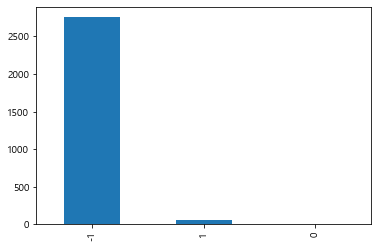

In [20]:
train_data['label'].value_counts().plot(kind='bar')

In [21]:
train_data['label'].value_counts().reset_index(drop=True)

0    2758
1      52
2       6
Name: label, dtype: int64

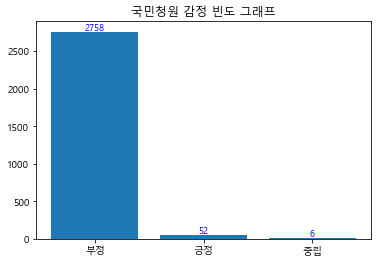

In [22]:
x = np.arange(3)
month = ['부정', '긍정', '중립']
value = train_data['label'].value_counts().reset_index(drop=True)

plt.bar(x, value)
plt.xticks(x, month)
plt.title('국민청원 감정 빈도 그래프')
for i, v in enumerate(x):
    plt.text(v, value[i], value[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='blue',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')

plt.show()
#plt.savefig('국민청원 월별 청원 수.png')

In [23]:
test_data['label'].value_counts()

-1    2755
 1       4
Name: label, dtype: int64

In [24]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']


X_train = []
for sentence in train_data['content']:
    temp_X = [] 
    temp_X = okt.morphs(sentence, stem=True) # 토큰화 
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 
    X_train.append(temp_X)


X_test = [] 
for sentence in test_data['content']: 
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화 
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 
    X_test.append(temp_X)


In [25]:
from keras.preprocessing.text import Tokenizer
max_words = 35000 
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

내용의 최대 길이 :  9102
내용의 평균 길이 :  479.3924005681818


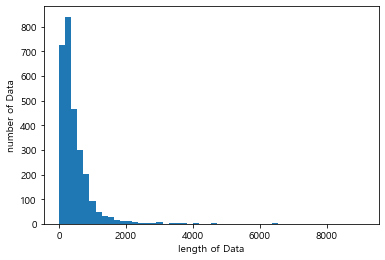

In [26]:
print("내용의 최대 길이 : ", max(len(l) for l in X_train)) 
print("내용의 평균 길이 : ", sum(map(len, X_train))/ len(X_train))
plt.hist([len(s) for s in X_train], bins=50) 
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()


내용의 최대 길이 :  4769
내용의 평균 길이 :  413.82384922073214


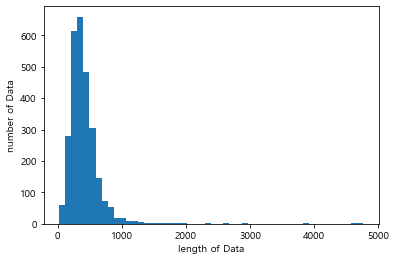

In [27]:
print("내용의 최대 길이 : ", max(len(l) for l in X_test))
print("내용의 평균 길이 : ", sum(map(len, X_test))/ len(X_test))
plt.hist([len(s) for s in X_test], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()


In [28]:
import numpy as np 
y_train = []
y_test = []
for i in range(len(train_data['label'])):
    if train_data['label'].iloc[i] == 1:
        y_train.append([0, 0, 1]) 
    elif train_data['label'].iloc[i] == 0:
        y_train.append([0, 1, 0]) 
    elif train_data['label'].iloc[i] == -1: 
        y_train.append([1, 0, 0])
        
for i in range(len(test_data['label'])): 
    if test_data['label'].iloc[i] == 1: 
        y_test.append([0, 0, 1]) 
    elif test_data['label'].iloc[i] == 0: 
        y_test.append([0, 1, 0]) 
    elif test_data['label'].iloc[i] == -1:
        y_test.append([1, 0, 0]) 
        
        
y_train = np.array(y_train) 
y_test = np.array(y_test)


In [29]:
y_train

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [30]:
y_test

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [31]:
len(X_train)

2816

In [32]:
len(X_test)

2759

In [33]:
len(y_train)

2816

In [34]:
len(y_test)

2759

In [35]:
from keras.layers import Embedding, Dense, LSTM 
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
max_len = 40 # 전체 데이터의 길이를 20로 맞춘다 
X_train = pad_sequences(X_train, maxlen=max_len) 
X_test = pad_sequences(X_test, maxlen=max_len)

In [36]:
model = Sequential() 
model.add(Embedding(max_words, 100))
model.add(LSTM(128)) 
model.add(Dense(3, activation='softmax')) 


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_split = 0.1)


Epoch 1/10
254/254 [==============================] - 17s 60ms/step - loss: 0.2688 - accuracy: 0.9593 - val_loss: 0.1099 - val_accuracy: 0.9716
Epoch 2/10
254/254 [==============================] - 17s 66ms/step - loss: 0.0626 - accuracy: 0.9843 - val_loss: 0.1178 - val_accuracy: 0.9716
Epoch 3/10
254/254 [==============================] - 16s 63ms/step - loss: 0.0347 - accuracy: 0.9937 - val_loss: 0.1479 - val_accuracy: 0.9716
Epoch 4/10
254/254 [==============================] - 15s 60ms/step - loss: 0.0156 - accuracy: 0.9966 - val_loss: 0.1335 - val_accuracy: 0.9787
Epoch 5/10
254/254 [==============================] - 15s 60ms/step - loss: 0.0118 - accuracy: 0.9980 - val_loss: 0.1455 - val_accuracy: 0.9716
Epoch 6/10
254/254 [==============================] - 16s 63ms/step - loss: 0.0108 - accuracy: 0.9966 - val_loss: 0.1987 - val_accuracy: 0.9752
Epoch 7/10
254/254 [==============================] - 16s 62ms/step - loss: 0.0014 - accuracy: 0.9999 - val_loss: 0.2255 - val_accuracy:

In [37]:
def model_builder(hp):
    model = Sequential()
    model.add(Embedding(max_words, 100))

    
    hp_units = hp.Int('units', min_value = 64, max_value = 256, step = 64)
    model.add(LSTM(units = hp_units))
    model.add(Dense(3, activation='softmax')) 

    
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.CategoricalCrossentropy(from_logits = True), 
                metrics = ['accuracy'])

    return model

In [38]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt2')

INFO:tensorflow:Reloading Oracle from existing project my_dir\intro_to_kt2\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\intro_to_kt2\tuner0.json


In [39]:
a = tuner.search(X_train, y_train, epochs = 10, validation_split = 0.1)

INFO:tensorflow:Oracle triggered exit


In [52]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [53]:
model = tuner.hypermodel.build(best_hps)

In [ ]:
history = model.fit(X_train, y_train, epochs = 10, batch_size = 100, validation_split = 0.2)

Epoch 1/10
23/23 [==============================] - 7s 228ms/step - loss: 1.0248 - accuracy: 0.5426 - val_loss: 0.9366 - val_accuracy: 0.5851
Epoch 2/10
23/23 [==============================] - 4s 186ms/step - loss: 0.8657 - accuracy: 0.6353 - val_loss: 0.8183 - val_accuracy: 0.6330
Epoch 3/10
23/23 [==============================] - 4s 186ms/step - loss: 0.6451 - accuracy: 0.7538 - val_loss: 0.6925 - val_accuracy: 0.7074
Epoch 4/10
23/23 [==============================] - 4s 184ms/step - loss: 0.3615 - accuracy: 0.8439 - val_loss: 1.0411 - val_accuracy: 0.7092
Epoch 5/10
23/23 [==============================] - 4s 184ms/step - loss: 0.1591 - accuracy: 0.9629 - val_loss: 0.8678 - val_accuracy: 0.7216
Epoch 6/10
23/23 [==============================] - 7s 307ms/step - loss: 0.0862 - accuracy: 0.9865 - val_loss: 1.2889 - val_accuracy: 0.7021
Epoch 7/10
23/23 [==============================] - 7s 296ms/step - loss: 0.0377 - accuracy: 0.9908 - val_loss: 1.0654 - val_accuracy: 0.7358
Epoch 

In [49]:
model.evaluate(X_test, y_test)

87/87 [==============================] - 1s 6ms/step - loss: 2.4863 - accuracy: 0.6441


[2.486314058303833, 0.6440739631652832]

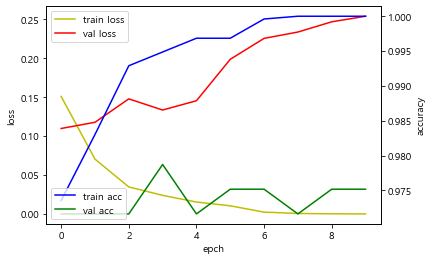

In [40]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

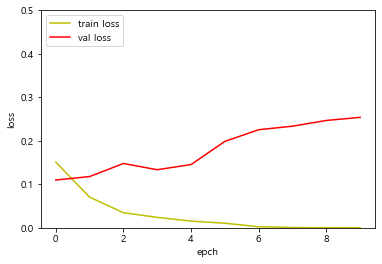

In [41]:
fig, loss_ax = plt.subplots()


loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')


loss_ax.set_xlabel('epch')
loss_ax.set_ylabel('loss')
loss_ax.set_ylim(0.00000000000000000001,0.5)

loss_ax.legend(loc='upper left')

plt.show()

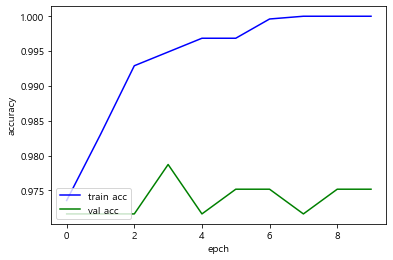

In [42]:
fig, acc_ax = plt.subplots()




acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

acc_ax.set_xlabel('epch')
acc_ax.set_ylabel('accuracy')

acc_ax.legend(loc='lower left')

plt.show()

In [43]:
print(" \n 테스트 정확도 : {:.2f}%".format(model.evaluate(X_test, y_test)[1] * 100))

87/87 [==============================] - 1s 11ms/step - loss: 0.0178 - accuracy: 0.9978
 
 테스트 정확도 : 99.78%


In [44]:
predict = model.predict(X_test)

In [45]:
import numpy as np 
predict_labels = np.argmax(predict, axis=1)
original_labels = np.argmax(y_test, axis=1)

In [47]:
original_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [48]:
labels_res = pd.DataFrame()

labels_res['original'] = pd.Series(original_labels)
labels_res['predict'] = pd.Series(predict_labels)
labels_res

,original,predict
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2754,0,0
2755,0,0
2756,0,0
2757,0,0


<AxesSubplot:>

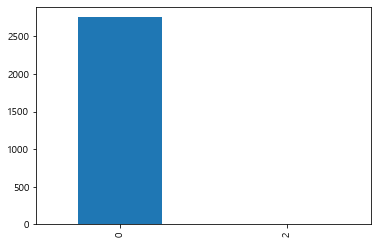

In [49]:
labels_res['original'].value_counts().plot(kind='bar')

In [50]:
original = labels_res['original'].value_counts().reset_index(drop=True)

In [51]:
x = np.arange(2)
month = ['부정', '긍정']
value = original.sort_index(ascending=True)

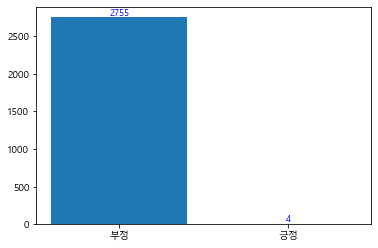

In [52]:
plt.bar(x, value)
plt.xticks(x, month)
for i, v in enumerate(x):
    plt.text(v, value[i], value[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='blue',
             horizontalalignment='center',  
             verticalalignment='bottom')

plt.show()
#plt.savefig('국민청원 월별 청원 수.png')

In [53]:
labels_res['predict'].value_counts()

0    2757
2       2
Name: predict, dtype: int64

In [54]:
x = np.arange(1)
month = ['부정']
value = labels_res['predict'].value_counts()

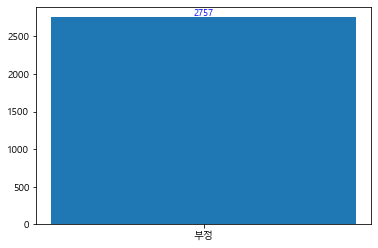

In [55]:
plt.bar(x, value, width = 0.4)
plt.xticks(x, month)
for i, v in enumerate(x):
    plt.text(v, value[i], value[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='blue',
             horizontalalignment='center', 
             verticalalignment='bottom')

plt.show()
#plt.savefig('국민청원 월별 청원 수.png')

In [56]:
labels_res['predict'].value_counts()

0    2757
2       2
Name: predict, dtype: int64

In [64]:
test2_data = my_content_df_2

<AxesSubplot:>

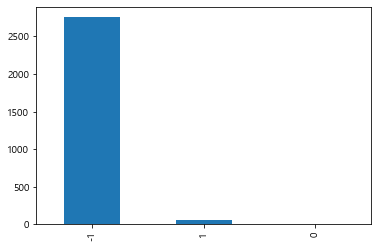

In [65]:
train_data['label'].value_counts().plot(kind='bar')

<AxesSubplot:>

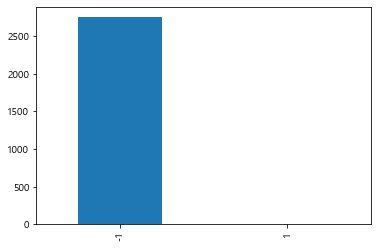

In [66]:
test2_data['label'].value_counts().plot(kind='bar')

In [68]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

X_train = []
for sentence in train_data['content']:
    temp_X = [] 
    temp_X = okt.morphs(sentence, stem=True) # 토큰화 
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 
    X_train.append(temp_X)

X_test_2 = [] 
for sentence in test2_data['content']: 
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화 
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 
    X_test_2.append(temp_X)


In [69]:
from keras.preprocessing.text import Tokenizer
max_words = 35000 
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test_2 = tokenizer.texts_to_sequences(X_test_2)

내용의 최대 길이 :  40
내용의 평균 길이 :  40.0


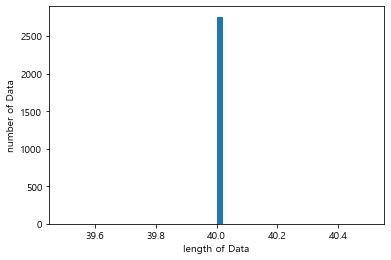

In [82]:
print("내용의 최대 길이 : ", max(len(l) for l in X_test_2))
print("내용의 평균 길이 : ", sum(map(len, X_test_2))/ len(X_test_2))
plt.hist([len(s) for s in X_test_2], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()


In [71]:
y_test_2 = []

        
for i in range(len(test2_data['label'])): 
    if test_data['label'].iloc[i] == 1: 
        y_test_2.append([0, 0, 1]) 
    elif test_data['label'].iloc[i] == 0: 
        y_test_2.append([0, 1, 0]) 
    elif test_data['label'].iloc[i] == -1:
        y_test_2.append([1, 0, 0]) 
        
        
y_test_2 = np.array(y_test)

In [72]:
from keras.layers import Embedding, Dense, LSTM 
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
X_test_2 = pad_sequences(X_test, maxlen=max_len)

In [73]:
print(" \n 테스트 정확도 : {:.2f}%".format(model.evaluate(X_test_2, y_test_2)[1] * 100))

87/87 [==============================] - 1s 10ms/step - loss: 0.0178 - accuracy: 0.9978
 
 테스트 정확도 : 99.78%


In [74]:
predict = model.predict(X_test_2)

In [75]:
import numpy as np 
predict_labels = np.argmax(predict, axis=1)
original_labels = np.argmax(y_test_2, axis=1)

In [77]:
labels_res = pd.DataFrame()

labels_res['original'] = pd.Series(original_labels)
labels_res['predict'] = pd.Series(predict_labels)
labels_res

,original,predict
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2754,0,0
2755,0,0
2756,0,0
2757,0,0


<AxesSubplot:>

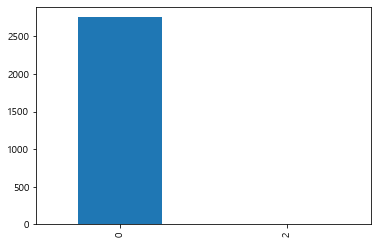

In [78]:
labels_res['original'].value_counts().plot(kind='bar') #0은 부정, 1은 중립 2는 긍정

In [79]:
labels_res['original'].value_counts()

0    2755
2       4
Name: original, dtype: int64

<AxesSubplot:>

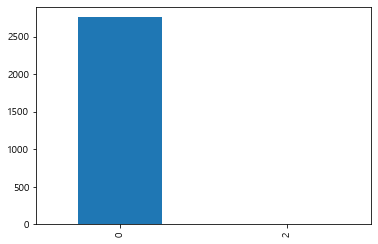

In [80]:
labels_res['predict'].value_counts().plot(kind='bar')


In [81]:
labels_res['predict'].value_counts()

0    2757
2       2
Name: predict, dtype: int64